# Intro

the dataset that will be used in this notebook is the [**Mapping 2019-nCoV**](https://systems.jhu.edu/research/public-health/ncov/) which contains several datasources (including the **WHO** and the **ECDC**) and it can be found [here](https://github.com/CSSEGISandData/COVID-19)

Particually, we will use the **CSSE COVID-19 Dataset** folder, which contains two *types* of data:

- Daily reports (csse_covid_19_daily_reports): <br>
    this folder contains daily aggregated case reports, wich contains information such the number of confirmed cases, the number of deaths, and the number of recovered cases.
    each report contains accumulated till the date of the report.
    we can use the last report to show statistic measures such as total number of cases for each country, most affected countries, etc ..., but we can perform time analysis on the data.
- Time series summary (csse_covid_19_time_series):

# Import Libraries and Read Data

In [3]:
import pandas as pd
import numpy as np
import emoji

import plotly
from plotly.offline import init_notebook_mode, iplot
import plotly.express as px

import plotly.graph_objects as go
from plotly.graph_objects import Bar

init_notebook_mode(connected=True)
plotly.offline.init_notebook_mode(connected=True)

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import squarify

sns.set()

The last report date is `03-29-2020`

In [4]:
last_report_path = 'COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/03-29-2020.csv'

In [5]:
df = pd.read_csv(last_report_path)

# Get to know the data

In [6]:
df.head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
0,45001.0,Abbeville,South Carolina,US,2020-03-29 23:08:25,34.223334,-82.461707,3,0,0,0,"Abbeville, South Carolina, US"
1,22001.0,Acadia,Louisiana,US,2020-03-29 23:08:25,30.295065,-92.414197,9,1,0,0,"Acadia, Louisiana, US"
2,51001.0,Accomack,Virginia,US,2020-03-29 23:08:25,37.767072,-75.632346,3,0,0,0,"Accomack, Virginia, US"
3,16001.0,Ada,Idaho,US,2020-03-29 23:08:25,43.452658,-116.241552,92,1,0,0,"Ada, Idaho, US"
4,19001.0,Adair,Iowa,US,2020-03-29 23:08:25,41.330756,-94.471059,1,0,0,0,"Adair, Iowa, US"


In [7]:
df.shape

(3434, 12)

In [8]:
len(df['Country_Region'].unique())

177

There are 3434 reported cases across 177 countries. 

Field description
- Province/State: China - province name; US/Canada/Australia/ - city name, state/province name; Others - name of the event (e.g., "Diamond Princess" cruise ship); other countries - blank.
- Country/Region: country/region name conforming to WHO (will be updated).
- Last Update: MM/DD/YYYY HH:mm (24 hour format, in UTC).
- Confirmed: the number of confirmed cases.
- Deaths: the number of deaths.
- Recovered: the number of recovered cases.

# Data Preprocessing

In [9]:
df.head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
0,45001.0,Abbeville,South Carolina,US,2020-03-29 23:08:25,34.223334,-82.461707,3,0,0,0,"Abbeville, South Carolina, US"
1,22001.0,Acadia,Louisiana,US,2020-03-29 23:08:25,30.295065,-92.414197,9,1,0,0,"Acadia, Louisiana, US"
2,51001.0,Accomack,Virginia,US,2020-03-29 23:08:25,37.767072,-75.632346,3,0,0,0,"Accomack, Virginia, US"
3,16001.0,Ada,Idaho,US,2020-03-29 23:08:25,43.452658,-116.241552,92,1,0,0,"Ada, Idaho, US"
4,19001.0,Adair,Iowa,US,2020-03-29 23:08:25,41.330756,-94.471059,1,0,0,0,"Adair, Iowa, US"


## 1 - Drop irrelevant columns:

`FIPS`: the **FIPS** represents the Federal Information Processing Standard state code, and it's related only to the `U.S.` states, we won't need it now (unless we want to draw a map specific to the `U.S.`)

`Admin2`: it's not clear what does this column means, will be dropped :)

`Province_State`: the city on which the case was recorded, but not all cases are associated with the city, so we will drop it.

In [10]:
df['Province_State'].isna().sum()

173

`Last_update`: the date on which this row was last updated, irrelvant to our analysis.

`Lat` and `Long_` columns specify the coordinates of the case, we won't be needing this inofrmation right now.

`Combined_Key`: this column is the concatenation of `Admin2`, `Province_State`, and ` 	Country_Region`, irrelvant too.

In [11]:
def drop_irrelevant_columns(df, irrelevant_columns):
    new_df = df.drop(columns=irrelevant_columns)
    return new_df

In [12]:
irrelevant_columns = ['FIPS', 'Admin2', 'Province_State', 'Last_Update', 'Lat', 'Long_', 'Combined_Key']

In [13]:
df = drop_irrelevant_columns(df, irrelevant_columns)

In [14]:
df.head()

,Country_Region,Confirmed,Deaths,Recovered,Active
0,US,3,0,0,0
1,US,9,1,0,0
2,US,3,0,0,0
3,US,92,1,0,0
4,US,1,0,0,0


## 2 - Normalize columns' names:

rename column `Country_Region` to `Country`, for easier manipulation

In [15]:
def rename_columns(df, columns_mapping):
    new_df = df.rename(columns=columns_mapping)
    return new_df

In [16]:
columns_mapping = {
    'Country_Region': 'Country'
}

In [17]:
df = rename_columns(df, columns_mapping)

In [18]:
df.head()

,Country,Confirmed,Deaths,Recovered,Active
0,US,3,0,0,0
1,US,9,1,0,0
2,US,3,0,0,0
3,US,92,1,0,0
4,US,1,0,0,0


## 3 - Aggregate data by countries:
aggregate the number of confirmed cases, number of deaths, number of reovered cases, and number of active cases for each country.

In [19]:
def apply_aggregation(df, group_by_column, sort_by_column):
    aggregate_df = df.groupby(by=group_by_column)\
                        .sum()\
                        .reset_index()\
                        .sort_values(by=sort_by_column, ascending=False)
    return aggregate_df

In [20]:
aggregated_df = apply_aggregation(df, group_by_column='Country', sort_by_column='Deaths')

In [21]:
aggregated_df.head(10)

,Country,Confirmed,Deaths,Recovered,Active
82,Italy,97689,10779,13030,73880
150,Spain,80110,6803,14709,58598
34,China,82122,3304,75582,3236
78,Iran,38309,2640,12391,23278
59,France,40708,2611,7226,30871
165,US,140886,2467,2665,0
169,United Kingdom,19780,1231,151,18398
117,Netherlands,10930,772,253,9905
63,Germany,62095,533,9211,52351
16,Belgium,10836,431,1359,9046


the number of `Confirmed` cases in each country should be equal to the sum of: `Deaths`, `Recovered`, and `Active`

In [22]:
aggregated_df['Confirmed'].eq(aggregated_df['Deaths'] + aggregated_df['Recovered'] + aggregated_df['Active']).sum()

175

In [24]:
aggregated_df.shape

(177, 5)

there are two countries, for which the condition doesn't hold, let's find them:

In [25]:
aggregated_df[aggregated_df['Confirmed'] != aggregated_df['Deaths'] + aggregated_df['Recovered'] + aggregated_df['Active']]

,Country,Confirmed,Deaths,Recovered,Active
165,US,140886,2467,2665,0
30,Canada,6280,64,466,0


<p style="font-size:200%;">🤔</p>

only the `U.S.` and `Canada` has no active cases.

## 4 - Focus on *Outbreaks*:
We will focus in this notebook only on countries with high **death tolls**, countires that are *nearly* affected by the pandemic will be discarded.

In [26]:
most_affected_countries_names = aggregated_df['Country'][:10].values

In [27]:
print(most_affected_countries_names)

['Italy' 'Spain' 'China' 'Iran' 'France' 'US' 'United Kingdom'
 'Netherlands' 'Germany' 'Belgium']


In [28]:
most_affected_df = aggregated_df[aggregated_df['Country'].isin(most_affected_countries_names)]

In [29]:
most_affected_df.head()

,Country,Confirmed,Deaths,Recovered,Active
82,Italy,97689,10779,13030,73880
150,Spain,80110,6803,14709,58598
34,China,82122,3304,75582,3236
78,Iran,38309,2640,12391,23278
59,France,40708,2611,7226,30871


# Data Visualization

## Pie Chart

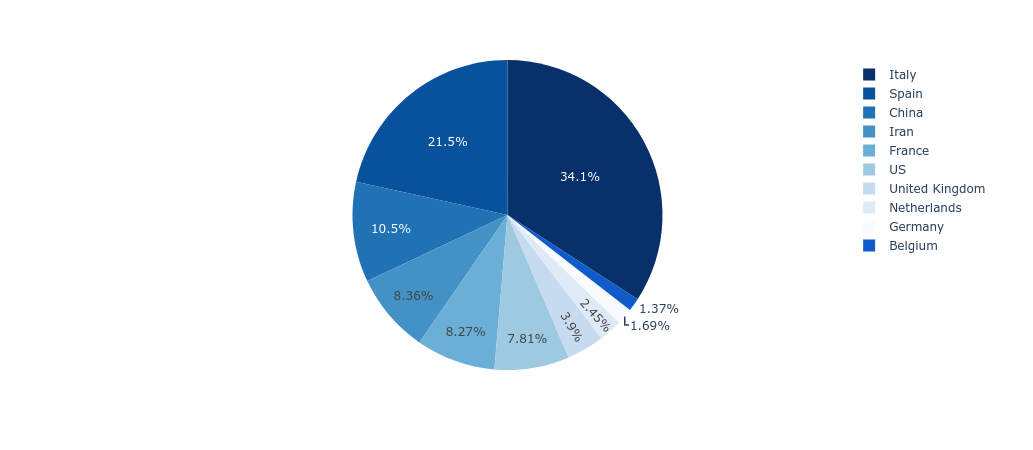

In [30]:
fig = px.pie(most_affected_df, names='Country', values='Deaths', color_discrete_sequence=px.colors.sequential.Blues_r)
fig.show()

## Treemap Chart

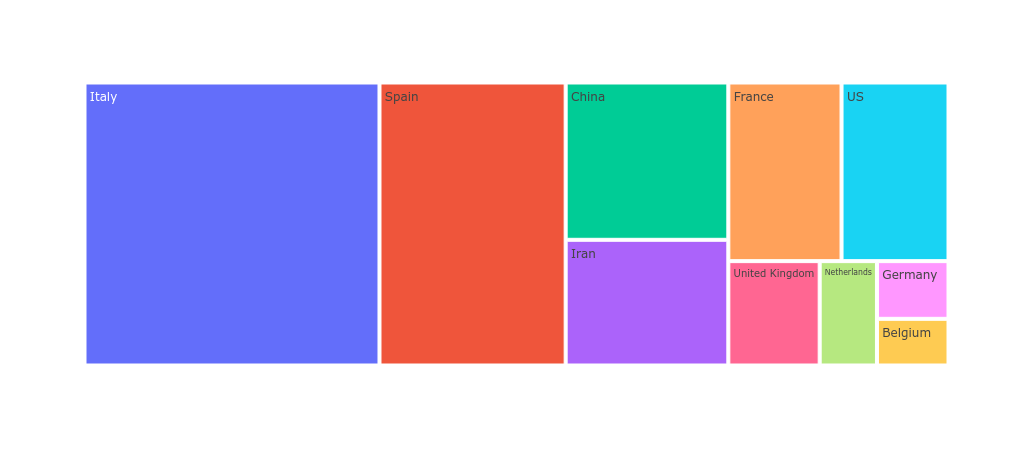

In [31]:
fig = px.treemap(most_affected_df, path=['Country'], values='Deaths')
fig.show()

## Stacked Bar Chart:

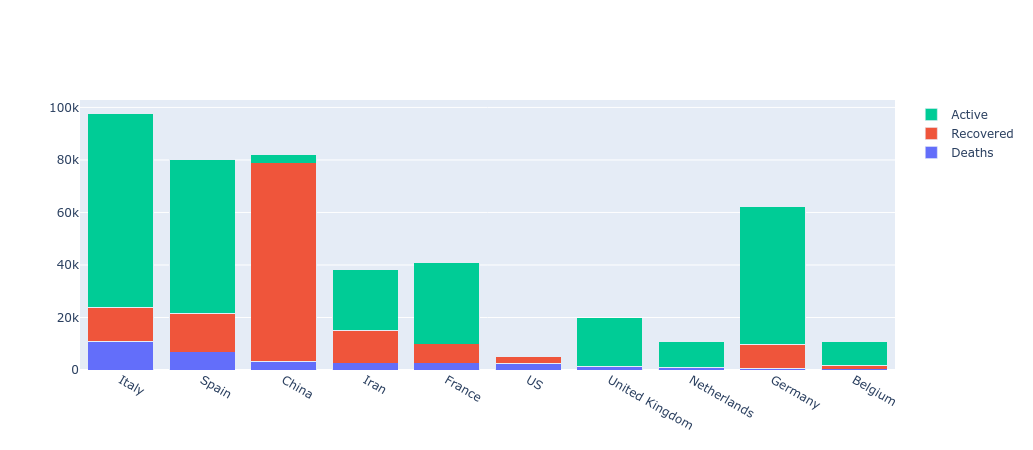

In [32]:
fig = go.Figure(data=[
    go.Bar(name='Deaths', x=most_affected_df['Country'], y=most_affected_df['Deaths']),
    go.Bar(name='Recovered', x=most_affected_df['Country'], y=most_affected_df['Recovered']),
    go.Bar(name='Active', x=most_affected_df['Country'], y=most_affected_df['Active']),
])
# Change the bar mode
fig.update_layout(barmode='stack')
fig.show()

## Horizontal Stacked Bar Chart

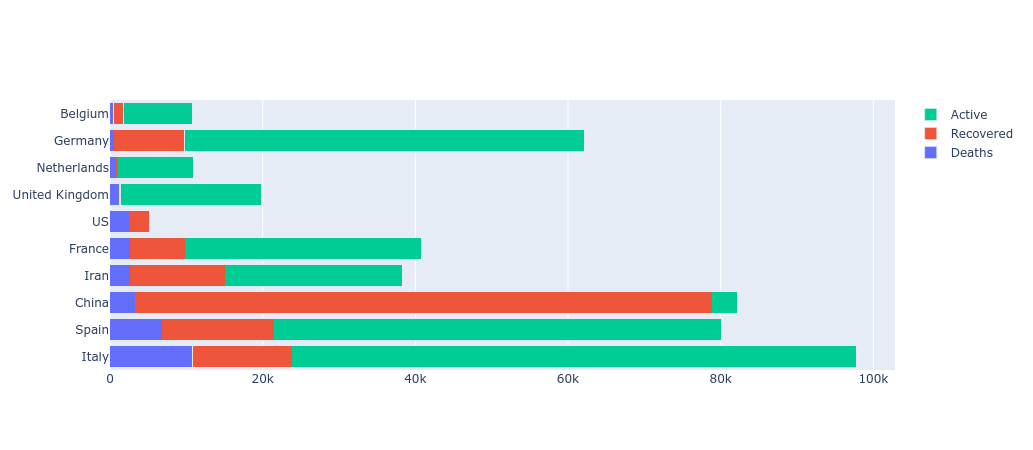

In [33]:
fig = go.Figure(data=[
    go.Bar(name='Deaths', x=most_affected_df['Deaths'], y=most_affected_df['Country'], orientation='h'),
    go.Bar(name='Recovered', x=most_affected_df['Recovered'], y=most_affected_df['Country'], orientation='h'),
    go.Bar(name='Active', x=most_affected_df['Active'], y=most_affected_df['Country'], orientation='h')
])
# Change the bar mode
fig.update_layout(barmode='stack')
fig.show()